## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.8]
redice_lr_patient = [5, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________________________________

Epoch 13/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3759 - accuracy: 0.5227 - val_loss: 1.5205 - val_accuracy: 0.4641
Epoch 14/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3562 - accuracy: 0.5288 - val_loss: 1.5177 - val_accuracy: 0.4663
Epoch 15/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3369 - accuracy: 0.5356 - val_loss: 1.5090 - val_accuracy: 0.4724
Epoch 16/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3209 - accuracy: 0.5416 - val_loss: 1.5110 - val_accuracy: 0.4692
Epoch 17/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3027 - accuracy: 0.5499 - val_loss: 1.5056 - val_accuracy: 0.4728
Epoch 18/25
49/49 [==============================] - 2s 48ms/step - loss: 1.2867 - accuracy: 0.5552 - val_loss: 1.5020 - val_accuracy: 0.4767
Epoch 19/25
49/49 [==============================] - 2s 48ms/step - loss: 1.2693 - accuracy: 0.5620 - val_loss: 1.4942 - val_accuracy: 0.4801
Epoch 

Epoch 1/25
49/49 [==============================] - 3s 52ms/step - loss: 2.3353 - accuracy: 0.2388 - val_loss: 2.1763 - val_accuracy: 0.1848
Epoch 2/25
49/49 [==============================] - 2s 45ms/step - loss: 1.8539 - accuracy: 0.3604 - val_loss: 2.0379 - val_accuracy: 0.2666
Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 1.7188 - accuracy: 0.4024 - val_loss: 1.9025 - val_accuracy: 0.3263
Epoch 4/25
49/49 [==============================] - 2s 45ms/step - loss: 1.6438 - accuracy: 0.4253 - val_loss: 1.7936 - val_accuracy: 0.3615
Epoch 5/25
49/49 [==============================] - 2s 45ms/step - loss: 1.5874 - accuracy: 0.4441 - val_loss: 1.7177 - val_accuracy: 0.3878
Epoch 6/25
49/49 [==============================] - 2s 46ms/step - loss: 1.5421 - accuracy: 0.4617 - val_loss: 1.6676 - val_accuracy: 0.4095
Epoch 7/25
49/49 [==============================] - 2s 46ms/step - loss: 1.5062 - accuracy: 0.4732 - val_loss: 1.6252 - val_accuracy: 0.4229
Epoch 8/25
49

49/49 [==============================] - 3s 63ms/step - loss: 0.4946 - accuracy: 0.8445 - val_loss: 1.5733 - val_accuracy: 0.5039
Epoch 22/25
49/49 [==============================] - 3s 61ms/step - loss: 0.4540 - accuracy: 0.8652 - val_loss: 1.6015 - val_accuracy: 0.5037
Epoch 23/25
49/49 [==============================] - 3s 56ms/step - loss: 0.4309 - accuracy: 0.8717 - val_loss: 1.6427 - val_accuracy: 0.5040
Epoch 24/25
49/49 [==============================] - 2s 50ms/step - loss: 0.4079 - accuracy: 0.8816 - val_loss: 1.6351 - val_accuracy: 0.5093
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8874
Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
49/49 [==============================] - 3s 64ms/step - loss: 0.3931 - accuracy: 0.8874 - val_loss: 1.6543 - val_accuracy: 0.5117
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "functional_13"
_________________________________________________________

Epoch 6/25
49/49 [==============================] - 3s 55ms/step - loss: 1.2438 - accuracy: 0.5703 - val_loss: 1.4752 - val_accuracy: 0.4850
Epoch 7/25
49/49 [==============================] - 3s 56ms/step - loss: 1.2019 - accuracy: 0.5848 - val_loss: 1.4593 - val_accuracy: 0.4834
Epoch 8/25
49/49 [==============================] - 2s 48ms/step - loss: 1.1619 - accuracy: 0.6002 - val_loss: 1.4911 - val_accuracy: 0.4772
Epoch 9/25
49/49 [==============================] - 2s 51ms/step - loss: 1.1266 - accuracy: 0.6142 - val_loss: 1.4561 - val_accuracy: 0.4912
Epoch 10/25
49/49 [==============================] - 3s 54ms/step - loss: 1.0952 - accuracy: 0.6259 - val_loss: 1.4652 - val_accuracy: 0.4877
Epoch 11/25
49/49 [==============================] - 2s 49ms/step - loss: 1.0647 - accuracy: 0.6367 - val_loss: 1.4570 - val_accuracy: 0.4865
Epoch 12/25
49/49 [==============================] - 2s 50ms/step - loss: 1.0357 - accuracy: 0.6478 - val_loss: 1.4404 - val_accuracy: 0.4955
Epoch 13/2

Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________________

49/49 [==============================] - 3s 55ms/step - loss: 1.0889 - accuracy: 0.6241 - val_loss: 1.9024 - val_accuracy: 0.3982
Epoch 11/25
49/49 [==============================] - 3s 54ms/step - loss: 1.0503 - accuracy: 0.6375 - val_loss: 1.6268 - val_accuracy: 0.4392
Epoch 12/25
49/49 [==============================] - 3s 55ms/step - loss: 1.0131 - accuracy: 0.6561 - val_loss: 1.6673 - val_accuracy: 0.4418
Epoch 13/25
49/49 [==============================] - 3s 55ms/step - loss: 0.9886 - accuracy: 0.6608 - val_loss: 2.3410 - val_accuracy: 0.3317
Epoch 14/25
49/49 [==============================] - 3s 55ms/step - loss: 0.9540 - accuracy: 0.6729 - val_loss: 1.8080 - val_accuracy: 0.3957
Epoch 15/25
48/49 [============================>.] - ETA: 0s - loss: 0.9193 - accuracy: 0.6875
Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
49/49 [==============================] - 3s 55ms/step - loss: 0.9197 - accuracy: 0.6876 - val_loss: 1.8925 - val_accuracy: 0.40

Epoch 1/25
49/49 [==============================] - 3s 56ms/step - loss: 1.9939 - accuracy: 0.3242 - val_loss: 2.1079 - val_accuracy: 0.2171
Epoch 2/25
49/49 [==============================] - 3s 52ms/step - loss: 1.6626 - accuracy: 0.4194 - val_loss: 1.9494 - val_accuracy: 0.3136
Epoch 3/25
49/49 [==============================] - 3s 52ms/step - loss: 1.5430 - accuracy: 0.4598 - val_loss: 1.7958 - val_accuracy: 0.3772
Epoch 4/25
49/49 [==============================] - 3s 52ms/step - loss: 1.4617 - accuracy: 0.4892 - val_loss: 1.7287 - val_accuracy: 0.3973
Epoch 5/25
49/49 [==============================] - 3s 52ms/step - loss: 1.3944 - accuracy: 0.5130 - val_loss: 1.6462 - val_accuracy: 0.4221
Epoch 6/25
49/49 [==============================] - 3s 53ms/step - loss: 1.3445 - accuracy: 0.5324 - val_loss: 1.5909 - val_accuracy: 0.4442
Epoch 7/25
49/49 [==============================] - 3s 52ms/step - loss: 1.2967 - accuracy: 0.5515 - val_loss: 1.5676 - val_accuracy: 0.4427
Epoch 8/25
49

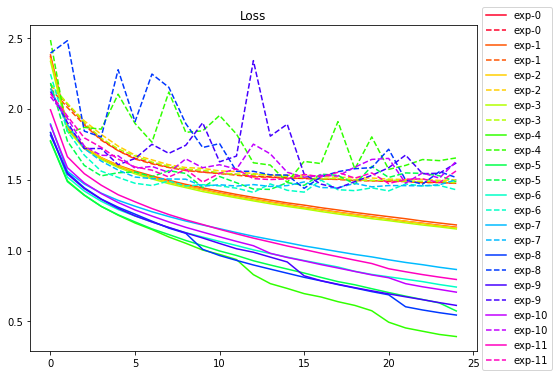

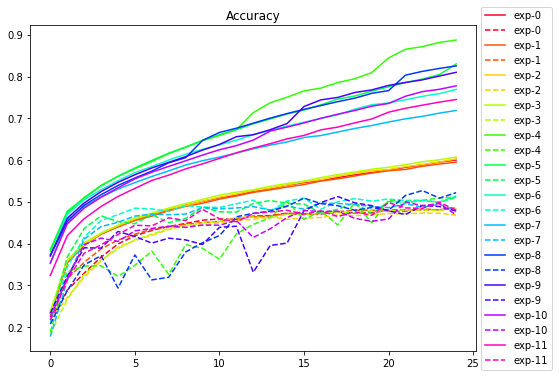

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()